In [29]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures
import category_encoders as ce
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_selector as selector



In [30]:
signdata = pd.read_csv('/Users/emilkoch/Library/Mobile Documents/com~apple~CloudDocs/Data Files/signdata.csv', encoding='latin-1')

In [31]:
# Separate target variable from features
X = signdata.drop(columns=['SignBankEnglishTranslations'])  # Features

# Separate numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['List', 'Item', 'EnglishWF(lg10)', 'SignFrequency(M)', 'SignFrequency(SD)', 'SignFrequency(Z)', 'SignFrequency(N)', 'Unknown', 'SignFrequency(M-Native)', 'SignFrequency(SD-Native)', 'SignFreq(Z-native)', 'SignFrequency(N-Native)', 'Unknown(Native)', 'SignFrequency(M-Nonnative)', 'SignFrequency(SD-Nonnative)', 'SignFrequency(N-Nonnative)', 'SignFreq(Z-Nonnative)', 'Unknown(Nonnative)', 'DominantTranslationAgreement', 'DominantTranslationAgreement(Native)', 'DominantTranslationAgreement(Nonnative)', 'Iconicity(M)', 'Iconicity(SD)', 'Iconicity(Z)', 'Iconicity(N)', 'D.Iconicity(M)', 'D.Iconicity(SD)', 'D.Iconicity(N)', 'D.Iconicity(Z)', 'D.Iconicity(M-native)', 'D.Iconicity(SD-native)', 'D.Iconicity(Z-native)', 'D.Iconicity(N-native)', 'GuessConsistency', 'GuessAccuracy', 'Transparency(M)', 'Transparency SD', 'Transparency Z', 'Initialized.2.0', 'FingerspelledLoanSign.2.0', 'Compound.2.0', 'NumberOfMorphemes.2.0', 'SignOnset(ms)', 'SignOffset(ms)', 'SignDuration(ms)', '

In [33]:
columns_to_drop = [
    'UlnarRotationM4.2.0', 'FlexionChangeM5.2.0', 'SpreadChangeM5.2.0',
    'SignTypeM5.2.0', 'MovementM5.2.0', 'RepeatedMovementM5.2.0',
    'MajorLocationM5.2.0', 'MinorLocationM5.2.0', 'SecondMinorLocationM5.2.0',
    'ContactM5.2.0', 'NonDominantHandshapeM5.2.0', 'UlnarRotationM5.2.0',
    'FlexionChangeM6.2.0', 'SpreadChangeM6.2.0', 'SignTypeM6.2.0',
    'MovementM6.2.0', 'RepeatedMovementM6.2.0', 'MajorLocationM6.2.0',
    'MinorLocationM6.2.0', 'SecondMinorLocationM6.2.0', 'ContactM6.2.0',
    'NonDominantHandshapeM6.2.0', 'UlnarRotationM6.2.0'
]
# Select columns not in columns_to_drop from X_numerical
X_numerical_2 = X_numerical.drop(columns=columns_to_drop)
# Impute missing values and scaling
imputer = SimpleImputer(strategy='median')
X_numerical_imputed = imputer.fit_transform(X_numerical_2) 
scaler = StandardScaler()
X_numerical_scaled  = scaler.fit_transform(X_numerical_imputed)  

In [34]:
# Check for missing values in the DataFrame
missing_values = X[categorical_cols].isnull().sum()
print("Missing values in categorical columns:")
print(missing_values)

# If there are missing values, handle them before preprocessing
if missing_values.sum() > 0:
    # Handle missing values using SimpleImputer with the most frequent strategy
    imputer = SimpleImputer(strategy='most_frequent')
    X[categorical_cols] = imputer.fit_transform(X[categorical_cols])

# Define the pipeline for categorical features
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))   # One-hot encode categorical features and produce a dense array
])

# Apply the pipeline to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_pipeline, categorical_cols)
    ],
    remainder='passthrough'  # Include non-categorical columns
)

# Fit and transform the data
X_encoded = preprocessor.fit_transform(X)

# Convert the encoded array to a DataFrame
X_encoded_df = pd.DataFrame(X_encoded) # type: ignore
print(X_encoded_df.isna().sum())

Missing values in categorical columns:
EntryID                     0
LemmaID                     0
Code                        0
Batch                       0
DominantTranslation      2083
                         ... 
SignBankAnnotationID      720
SignBankLemmaID           734
SignBankSemanticField     733
InCDI                       0
CDISemanticCategory      2155
Length: 61, dtype: int64
0           0
1           0
2           0
3           0
4           0
         ... 
14083       0
14084      26
14085     734
14086    2190
14087    2190
Length: 14088, dtype: int64


In [35]:
# Check data types of all columns in X_encoded_df
data_types = X_encoded_df.dtypes

# Check if any column has a non-numeric data type
non_numeric_columns = data_types[data_types != 'float64'][data_types != 'int64']

# Print any non-numeric columns
if not non_numeric_columns.empty:
    print("Non-numeric columns found after one-hot encoding:")
    print(non_numeric_columns)
else:
    print("All columns are numeric after one-hot encoding.")


All columns are numeric after one-hot encoding.


In [36]:
# Concatenate numerical and encoded categorical columns
X_processed = pd.concat([pd.DataFrame(X_numerical_scaled), X_encoded_df], axis=1)

# Check for missing values in the processed DataFrame
missing_values_processed = X_processed.isnull().sum()
print("Missing values in processed DataFrame:")
print(missing_values_processed)

# Replace NaN values with 0
X_processed.fillna(0, inplace=True)
print(X_processed.isnull().sum())

Missing values in processed DataFrame:
0           0
1           0
2           0
3           0
4           0
         ... 
14083       0
14084      26
14085     734
14086    2190
14087    2190
Length: 14194, dtype: int64
0        0
1        0
2        0
3        0
4        0
        ..
14083    0
14084    0
14085    0
14086    0
14087    0
Length: 14194, dtype: int64


In [37]:
# Drop NaN values from the target variable
y_cleaned = signdata['SignBankEnglishTranslations'].dropna()

# Index X_processed with the same indices as y_cleaned
X_processed_cleaned = X_processed.loc[y_cleaned.index]

print("Shape of X_processed:", X_processed_cleaned.shape)
print("Shape of y_encoded:", y_cleaned.shape)  # Adjusted to use y_cleaned.shape for consistency

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the target variable
y_encoded = label_encoder.fit_transform(y_cleaned)

# Check for NaN values in the target variable after dropping
nan_count_after_drop = y_cleaned.isnull().sum()
print("Number of NaN values in 'SignBankEnglishTranslations' column after dropping:", nan_count_after_drop)
# Check for NaN values in X_processed_cleaned after dropping NaN values from the target variable
nan_count_in_processed = X_processed_cleaned.isna().sum()
print('Number of NaN values in X_processed_cleaned:', nan_count_in_processed)

Shape of X_processed: (1984, 14194)
Shape of y_encoded: (1984,)
Number of NaN values in 'SignBankEnglishTranslations' column after dropping: 0
Number of NaN values in X_processed_cleaned: 0        0
1        0
2        0
3        0
4        0
        ..
14083    0
14084    0
14085    0
14086    0
14087    0
Length: 14194, dtype: int64


In [25]:
# Initialize the decision tree classifier
tree_clf = DecisionTreeClassifier()

# Fit the decision tree model to the data
tree_clf.fit(X_processed_cleaned, y_encoded)

# Extract feature importances
feature_importances = tree_clf.feature_importances_

# Sort feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_processed_cleaned .shape[1]), feature_importances[sorted_indices])
plt.xticks(range(X_processed_cleaned .shape[1]), X_processed_cleaned.columns[sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

KeyboardInterrupt: 

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed_cleaned, y_encoded, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to store feature importances along with feature names
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top n most important features
n = 10  # Number of top features to display
print("Top", n, "most important features:")
print(feature_importance_df.head(n))

Top 10 most important features:
       Feature  Importance
14186    14080    0.003160
21          21    0.003081
14105    13999    0.002935
101        101    0.002931
14068    13962    0.002930
14083    13977    0.002911
22          22    0.002877
10          10    0.002873
1            1    0.002867
14069    13963    0.002855


In [38]:
# Print class distribution before resampling
print("Class distribution before resampling:")
print(Counter(y_encoded)) # type: ignore

# Initialize RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Resample the data
X_resampled, y_resampled = oversampler.fit_resample(X_processed_cleaned, y_cleaned)

# Print class distribution after resampling
print("Class distribution after resampling:")
print(Counter(y_resampled))

# Calculate class distribution after resampling
class_counts_after = Counter(y_resampled)

Class distribution before resampling:
Counter({700: 4, 975: 4, 245: 3, 1514: 3, 1437: 3, 1331: 3, 819: 3, 757: 3, 1217: 3, 1634: 2, 978: 2, 1247: 2, 744: 2, 699: 2, 1670: 2, 992: 2, 670: 2, 1434: 2, 943: 2, 432: 2, 395: 2, 1346: 2, 67: 2, 641: 2, 1019: 2, 1708: 2, 1162: 2, 472: 2, 1290: 2, 575: 2, 945: 2, 439: 2, 1376: 2, 1308: 2, 443: 2, 1496: 2, 1699: 2, 1725: 2, 1586: 2, 352: 2, 467: 2, 312: 2, 630: 2, 1298: 2, 1447: 2, 1712: 2, 449: 2, 1482: 2, 46: 2, 1782: 2, 855: 2, 226: 2, 925: 2, 63: 2, 207: 2, 351: 2, 102: 2, 1591: 2, 762: 2, 79: 2, 1236: 2, 1026: 2, 559: 2, 548: 2, 133: 2, 687: 2, 1117: 2, 1266: 2, 725: 2, 899: 2, 1097: 2, 1286: 2, 994: 2, 1554: 2, 965: 2, 685: 2, 349: 2, 187: 2, 1213: 2, 1171: 2, 1028: 2, 289: 2, 971: 2, 1045: 2, 513: 2, 544: 2, 845: 2, 1581: 2, 1279: 2, 1580: 2, 898: 2, 1423: 2, 1481: 2, 1660: 2, 781: 2, 596: 2, 1173: 2, 1030: 2, 1683: 2, 94: 2, 329: 2, 1752: 2, 911: 2, 633: 2, 1525: 2, 662: 2, 1249: 2, 441: 2, 884: 2, 1509: 2, 934: 2, 569: 2, 827: 2, 199: 

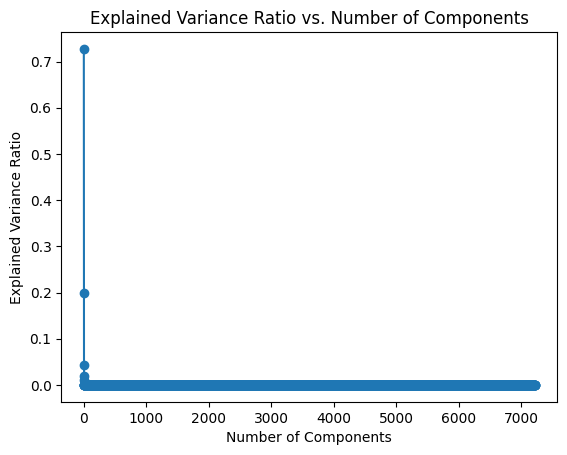

In [22]:
import matplotlib.pyplot as plt

# Fit PCA with a range of components
pca = PCA()
pca.fit(X_resampled)

# Plot explained variance ratio
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.show()

In [31]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from transformers import TFDistilBertModel, DistilBertTokenizer
import tensorflow as tf

# Split the dataset into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define a simple classification model using TensorFlow
inputs = tf.keras.Input(shape=(X_train.shape[1],))  # Adjust the input shape based on the combined feature representation
x = tf.keras.layers.Dense(64, activation='relu')(inputs)  # Add additional layers as needed
outputs = tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')(x)
classifier_model = tf.keras.Model(inputs, outputs)

# Compile the model
classifier_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
classifier_model.fit(X_train, y_train_encoded, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model
accuracy = classifier_model.evaluate(X_test, y_test_encoded)[1]
print("Accuracy:", accuracy)

Epoch 1/5
127/127 [==============================] - 4s 21ms/step - loss: 7.9784 - accuracy: 0.0000e+00 - val_loss: 7.5135 - val_accuracy: 0.0000e+00
Epoch 2/5
127/127 [==============================] - 2s 14ms/step - loss: 7.4781 - accuracy: 4.9529e-04 - val_loss: 7.5217 - val_accuracy: 0.0000e+00
Epoch 3/5
127/127 [==============================] - 3s 21ms/step - loss: 7.3782 - accuracy: 0.0012 - val_loss: 7.4645 - val_accuracy: 0.0000e+00
Epoch 4/5
127/127 [==============================] - 2s 17ms/step - loss: 7.2911 - accuracy: 7.4294e-04 - val_loss: 7.4351 - val_accuracy: 0.0000e+00
Epoch 5/5
68/68 [==============================] - 0s 6ms/step - loss: 7.2957 - accuracy: 9.2421e-04
Accuracy: 0.0009242144296877086


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold

# Split the dataset into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Remove constant features
constant_filter = VarianceThreshold()
X_train_filtered = constant_filter.fit_transform(X_train)
X_test_filtered = constant_filter.transform(X_test)

# Perform feature selection with SelectKBest
k_best_selector = SelectKBest(score_func=f_classif, k=20)
X_train_selected = k_best_selector.fit_transform(X_train_filtered, y_train)
X_test_selected = k_best_selector.transform(X_test_filtered)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


In [37]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf 

# Reshape the input data for RNN
X_train_rnn = X_train_selected.reshape(X_train_selected.shape[0], 1, X_train_selected.shape[1])  # (batch_size, timesteps, features)
X_test_rnn = X_test_selected.reshape(X_test_selected.shape[0], 1, X_test_selected.shape[1])

# Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define model
inputs = tf.keras.Input(shape=(1, X_train_selected.shape[1]))  # Shape should be (batch_size, timesteps, features)
x = tf.keras.layers.LSTM(64)(inputs)
outputs = tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')(x)
rnn_model = tf.keras.Model(inputs, outputs)

# Compile the model
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
rnn_model.fit(X_train_rnn, y_train_encoded, epochs=15, batch_size=32, validation_split=0.2)

# Evaluate the model
accuracy = rnn_model.evaluate(X_test_rnn, y_test_encoded)[1]
print("Accuracy:", accuracy)

Epoch 1/15
127/127 [==============================] - 7s 15ms/step - loss: 7.5044 - accuracy: 0.0012 - val_loss: 7.5121 - val_accuracy: 0.0000e+00
Epoch 2/15
127/127 [==============================] - 1s 6ms/step - loss: 7.4865 - accuracy: 0.0057 - val_loss: 7.5117 - val_accuracy: 0.0000e+00
Epoch 3/15
127/127 [==============================] - 1s 7ms/step - loss: 7.4533 - accuracy: 0.0087 - val_loss: 7.5140 - val_accuracy: 0.0000e+00
Epoch 4/15
127/127 [==============================] - 1s 6ms/step - loss: 7.3758 - accuracy: 0.0077 - val_loss: 7.5009 - val_accuracy: 0.0000e+00
Epoch 5/15
127/127 [==============================] - 1s 7ms/step - loss: 7.2696 - accuracy: 0.0074 - val_loss: 7.5149 - val_accuracy: 0.0000e+00
Epoch 6/15
127/127 [==============================] - 1s 6ms/step - loss: 7.1729 - accuracy: 0.0089 - val_loss: 7.5169 - val_accuracy: 0.0000e+00
Epoch 7/15
127/127 [==============================] - 1s 7ms/step - loss: 7.0914 - accuracy: 0.0077 - val_loss: 7.5361 - va

In [40]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf 

# Perform feature selection with SelectKBest
k_best_selector = SelectKBest(score_func=f_classif, k=100)
X_train_selected = k_best_selector.fit_transform(X_train_filtered, y_train)
X_test_selected = k_best_selector.transform(X_test_filtered)

# Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define model
inputs = tf.keras.Input(shape=(X_train_selected.shape[1],))
x = tf.keras.layers.BatchNormalization()(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Adding dropout for regularization
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Adding dropout for regularization
outputs = tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')(x)
rnn_model = tf.keras.Model(inputs, outputs)

# Compile the model
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
rnn_model.fit(X_train_selected, y_train_encoded, epochs=15, batch_size=32, validation_split=0.2)

# Evaluate the model
accuracy = rnn_model.evaluate(X_test_selected, y_test_encoded)[1]
print("Accuracy:", accuracy)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Epoch 1/15
127/127 [==============================] - 3s 8ms/step - loss: 7.5058 - accuracy: 0.0000e+00 - val_loss: 7.5103 - val_accuracy: 9.9010e-04
Epoch 2/15
127/127 [==============================] - 1s 6ms/step - loss: 7.3808 - accuracy: 0.0037 - val_loss: 7.4337 - val_accuracy: 9.9010e-04
Epoch 3/15
127/127 [==============================] - 1s 6ms/step - loss: 7.1799 - accuracy: 0.0067 - val_loss: 7.3538 - val_accuracy: 0.0089
Epoch 4/15
127/127 [==============================] - 1s 6ms/step - loss: 7.0462 - accuracy: 0.0146 - val_loss: 7.4629 - val_accuracy: 0.0158
Epoch 5/15
127/127 [==============================] - 1s 6ms/step - loss: 6.9655 - accuracy: 0.0188 - val_loss: 7.5590 - val_accuracy: 0.0218
Epoch 6/15
127/127 [==============================] - 1s 6ms/step - loss: 6.9007 - accuracy: 0.0238 - val_loss: 7.6787 - val_accuracy: 0.0228
Epoch 7/15
127/127 [==============================] - 1s 8ms/step - loss: 6.8445 - accuracy: 0.0292 - val_loss: 7.6368 - val_accuracy: 0

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf 

# Split the dataset into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Reshape the input data for RNN
X_train_rnn = np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])  # (batch_size, timesteps, features)
X_test_rnn = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])

# Define model
inputs = tf.keras.Input(shape=(1, X_train.shape[1]))  # Shape should be (batch_size, timesteps, features)
x = tf.keras.layers.LSTM(64)(inputs)
outputs = tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')(x)
rnn_model = tf.keras.Model(inputs, outputs)

# Compile the model
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
rnn_model.fit(X_train_rnn, y_train_encoded, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model
accuracy = rnn_model.evaluate(X_test_rnn, y_test_encoded)[1]
print("Accuracy:", accuracy)

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf 
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Split the dataset into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Perform feature selection with SelectKBest
k_best_selector = SelectKBest(score_func=f_classif, k=100)
X_train_selected = k_best_selector.fit_transform(X_train_filtered, y_train)
X_test_selected = k_best_selector.transform(X_test_filtered)

# Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Reshape the input data for RNN
X_train_rnn = np.array(X_train_selected).reshape(X_train_selected.shape[0], 1, X_train_selected.shape[1])  # (batch_size, timesteps, features)
X_test_rnn = np.array(X_test_selected).reshape(X_test_selected.shape[0], 1, X_test_selected.shape[1])

# Define model
inputs = tf.keras.Input(shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]))  # Shape should be (batch_size, timesteps, features)
x = LSTM(64, return_sequences=True)(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)  # Dropout with 20% dropout rate
x = LSTM(64, return_sequences=True)(x)  # Add another LSTM layer
x = BatchNormalization()(x)
x = Dropout(0.2)(x)  # Dropout with 20% dropout rate
x = LSTM(64)(x)
x = Dense(32, activation='relu')(x)  # Additional dense layer
outputs = Dense(len(label_encoder.classes_), activation='softmax')(x)
rnn_model = tf.keras.Model(inputs, outputs)

# Compile the model
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
rnn_model.fit(X_train_rnn, y_train_encoded, epochs=15, batch_size=32, validation_split=0.2)

# Evaluate the model
accuracy = rnn_model.evaluate(X_test_rnn, y_test_encoded)[1]
print("Accuracy:", accuracy)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Epoch 1/15
127/127 [==============================] - 17s 32ms/step - loss: 7.4868 - accuracy: 0.0020 - val_loss: 7.5150 - val_accuracy: 0.0000e+00
Epoch 2/15
127/127 [==============================] - 1s 10ms/step - loss: 7.2307 - accuracy: 0.0022 - val_loss: 7.5205 - val_accuracy: 0.0000e+00
Epoch 3/15
127/127 [==============================] - 1s 10ms/step - loss: 7.0018 - accuracy: 0.0109 - val_loss: 7.4878 - val_accuracy: 0.0020
Epoch 4/15
127/127 [==============================] - 1s 10ms/step - loss: 6.8329 - accuracy: 0.0215 - val_loss: 7.4186 - val_accuracy: 0.0059
Epoch 5/15
127/127 [==============================] - 1s 10ms/step - loss: 6.7287 - accuracy: 0.0312 - val_loss: 7.3351 - val_accuracy: 0.0129
Epoch 6/15
127/127 [==============================] - 1s 11ms/step - loss: 6.6657 - accuracy: 0.0391 - val_loss: 7.3427 - val_accuracy: 0.0158
Epoch 7/15
127/127 [==============================] - 1s 10ms/step - loss: 6.6197 - accuracy: 0.0456 - val_loss: 7.3810 - val_accurac